### Step 1: Define a mini batch of 2D embeddings (4 samples)

### Step 2: Define 2 cluster centers (2D)

In [2]:
# DEC-style Soft Assignment: Minimal Example

import numpy as np
import pandas as pd


batch = np.array([
    [1.0, 2.0],
    [2.0, 1.0],
    [8.0, 8.0],
    [9.0, 9.0]
])  # Shape: (4, 2) --> [num_samples, hidden_layer]


cluster_centers = np.array([
    [1.0, 1.0],
    [9.0, 8.0]
])  # Shape: (2, 2) --> [num_clusters, hidden_layer]



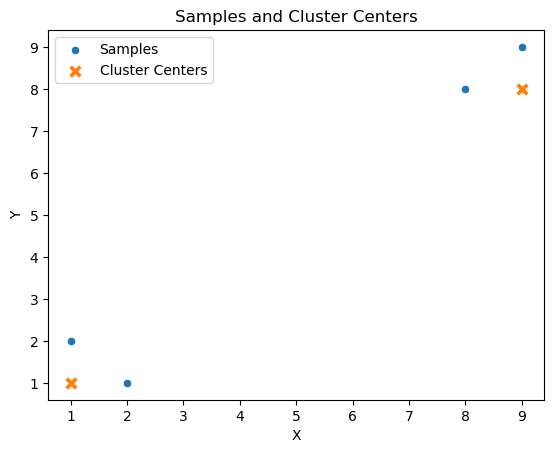

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=batch[:, 0], y=batch[:, 1], label='Samples')
sns.scatterplot(x=cluster_centers[:, 0], y=cluster_centers[:, 1], label='Cluster Centers', marker='X', s=100)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples and Cluster Centers')
plt.show()

### Step 3: Compute squared Euclidean distance between each point and each cluster

In [ ]:
# Shape explanation:
#   batch.unsqueeze(1): (4, 1, 2)
#   cluster_centers: (2, 2) → broadcasted to (1, 2, 2)
#   Result: (4, 2, 2) → Sum over dim=2 → (4, 2)


print(f"First data point - 2nd cluster:\n{batch[:, np.newaxis, :][0]} - {cluster_centers[1]} = {batch[:, np.newaxis, :][0] - cluster_centers[1]}")
print(f"\npower of 2: {(batch[:, np.newaxis, :][0] - cluster_centers[1])**2}\n")
norm_squared = np.sum((batch[:, np.newaxis, :] - cluster_centers) ** 2, axis=2)
print(f"Sum[1]: {norm_squared[0][1]}\n")

# ----------------------------------------------
print("Squared distances (all SUM's):\n", norm_squared)

First data point - 2nd cluster:
[[1. 2.]] - [9. 8.] = [[-8. -6.]]

power of 2: [[64. 36.]]

Sum[1]: 100.0

Squared distances (all SUM's):
 [[  1. 100.]
 [  1.  98.]
 [ 98.   1.]
 [128.   1.]]


### Step 4: Apply the Student's t-distribution kernel

In [37]:
alpha = 1.0  # Distribution parameter (sharper vs flatter assignments)

numerator = 1.0 / (1.0 + norm_squared / alpha)
print(f"Numerator (alpha=1): \n{numerator}")


Numerator (alpha=1): 
[[0.5        0.00990099]
 [0.5        0.01010101]
 [0.01010101 0.5       ]
 [0.00775194 0.5       ]]


In [ ]:
power = (alpha + 1.0) / 2
numerator = numerator ** power # if alpha == 1, nothing changes

print(f"Numerator (alpha=1): \n{numerator}")

Numerator (alpha=1): 
[[0.5        0.00990099]
 [0.5        0.01010101]
 [0.01010101 0.5       ]
 [0.00775194 0.5       ]]


### Step 5: Normalize across clusters (dim=1)

In [43]:
sum = np.sum(numerator, axis=1, keepdims=True)

print(f"Sum per line: \n{sum}")

soft_assignments = numerator / sum

print("\nSoft assignments (probabilities):\n", soft_assignments)

Sum per line: 
[[0.50990099]
 [0.51010101]
 [0.51010101]
 [0.50775194]]

Soft assignments (probabilities):
 [[0.98058252 0.01941748]
 [0.98019802 0.01980198]
 [0.01980198 0.98019802]
 [0.01526718 0.98473282]]


In [44]:
# Optional: convert to DataFrame for readability
df = pd.DataFrame(soft_assignments, columns=["Cluster 0", "Cluster 1"])
df.index.name = "Sample"
print("\nAssignment Table:\n", df)


Assignment Table:
         Cluster 0  Cluster 1
Sample                      
0        0.980583   0.019417
1        0.980198   0.019802
2        0.019802   0.980198
3        0.015267   0.984733


### Distribution of Q and P

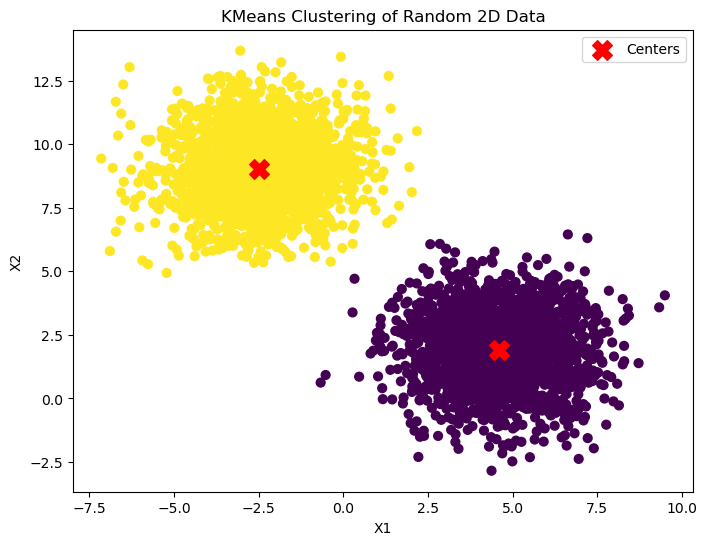

In [3]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Generate random 2D data with Gaussian noise
X, _ = make_blobs(n_samples=4000, centers=2, n_features=2, random_state=42)
X = X + np.random.normal(loc=0.0, scale=1, size=X.shape)

# Cluster using KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

# Plot the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=40)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centers')
plt.title('KMeans Clustering of Random 2D Data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

In [4]:
centroids = kmeans.cluster_centers_
centroids

array([[ 4.60240298,  1.89175395],
       [-2.49946237,  9.01628314]])

In [5]:
norm_squared = np.sum((X[:, np.newaxis, :] - centroids) ** 2, axis=2)

alpha = 1.0 # degrees of freedom

numerator = 1.0 / (1.0 + norm_squared / alpha)

sum = np.sum(numerator, axis=1, keepdims=True)

soft_assignments = numerator / sum

In [6]:
soft_assignments.shape

(4000, 2)

In [ ]:
ponto = 55

print(f"Matriz Q[0]: \n{soft_assignments[ponto]}") # bigger probability for cluster 1

print(f"\nLabel[0]: {labels[ponto]}")

Matriz Q[0]: 
[0.98679191 0.01320809]

Label[0]: 0


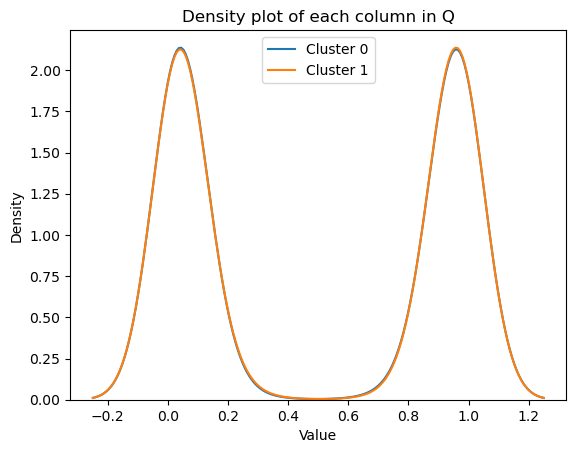

In [9]:
import seaborn as sns

for i in range(soft_assignments.shape[1]):
    sns.kdeplot(soft_assignments[:, i], label=f"Cluster {i}")
plt.title("Density plot of each column in Q")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


### Target Distribution P

In [10]:
import torch

soft_assignements_torch = torch.from_numpy(soft_assignments)

weight = (soft_assignements_torch ** 2) / torch.sum(soft_assignements_torch, 0)
target_distribution = (weight.t() / torch.sum(weight, 1)).t()

In [14]:
print(target_distribution[:,1].sum())

tensor(2000.3309, dtype=torch.float64)


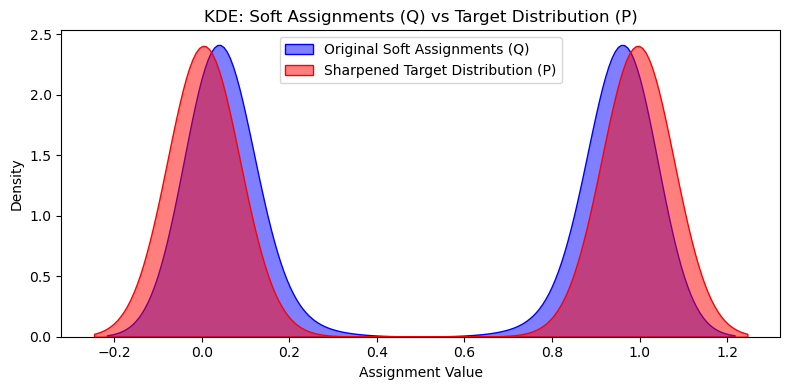

In [113]:
# Flatten both to 1D arrays for KDE plot
q_flat = soft_assignments.flatten()
p_flat = target_distribution.flatten().detach().numpy()

# Plot KDE
plt.figure(figsize=(8, 4))
sns.kdeplot(q_flat, label="Original Soft Assignments (Q)", fill=True, color="blue", alpha=0.5)
sns.kdeplot(p_flat, label="Sharpened Target Distribution (P)", fill=True, color="red", alpha=0.5)
plt.title("KDE: Soft Assignments (Q) vs Target Distribution (P)")
plt.xlabel("Assignment Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

### What target distribution P does to Soft Assignment Matrix P?

It basically sharpens distribution Q, so it has more certainty on the clusters

In [130]:
import numpy as np

# Copy to avoid modifying original array
reduced = soft_assignments.copy()

# Find index of max in each row
max_indices = np.argmax(reduced, axis=1)
min_indices = np.argmin(reduced,axis=1)

# Subtract 0.5 from the max value in each row
rows = np.arange(reduced.shape[0])
factor = 0.3
reduced[rows, max_indices] -= factor
reduced[rows,min_indices] += factor

print(reduced)

[[0.32282944 0.67717056]
 [0.31798973 0.68201027]
 [0.67602012 0.32397988]
 ...
 [0.32129343 0.67870657]
 [0.66794095 0.33205905]
 [0.67387988 0.32612012]]


In [131]:
import torch

soft_assignements_torch = torch.from_numpy(reduced)

weight = (soft_assignements_torch ** 2) / torch.sum(soft_assignements_torch, 0)
target_distribution = (weight.t() / torch.sum(weight, 1)).t()

In [133]:
target_distribution

tensor([[0.1860, 0.8140],
        [0.1794, 0.8206],
        [0.8140, 0.1860],
        ...,
        [0.1839, 0.8161],
        [0.8027, 0.1973],
        [0.8111, 0.1889]], dtype=torch.float64)

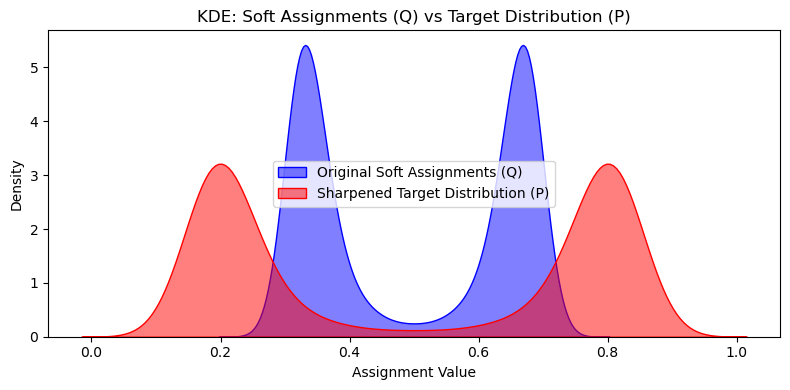

In [132]:
# Flatten both to 1D arrays for KDE plot
q_flat = reduced.flatten()
p_flat = target_distribution.flatten().detach().numpy()

# Plot KDE
plt.figure(figsize=(8, 4))
sns.kdeplot(q_flat, label="Original Soft Assignments (Q)", fill=True, color="blue", alpha=0.5)
sns.kdeplot(p_flat, label="Sharpened Target Distribution (P)", fill=True, color="red", alpha=0.5)
plt.title("KDE: Soft Assignments (Q) vs Target Distribution (P)")
plt.xlabel("Assignment Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

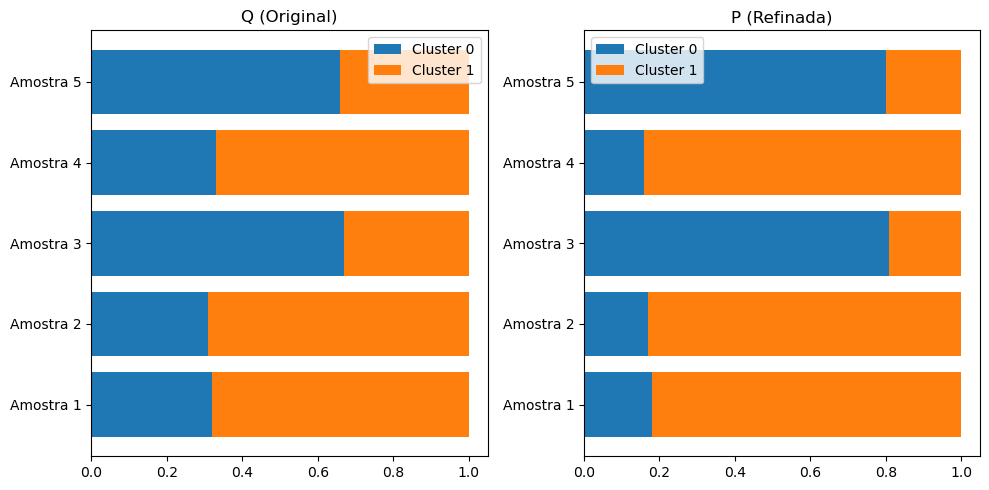

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Exemplo com 5 amostras
Q = np.array([[0.32, 0.68],
              [0.31, 0.69],
              [0.67, 0.33],
              [0.33, 0.67],
              [0.66, 0.34]])

P = np.array([[0.18, 0.82],
              [0.17, 0.83],
              [0.81, 0.19],
              [0.16, 0.84],
              [0.80, 0.20]])

labels = [f"Amostra {i+1}" for i in range(5)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, (matrix, title) in enumerate(zip([Q, P], ['Q (Original)', 'P (Refinada)'])):
    axs[i].barh(labels, matrix[:,0], label='Cluster 0')
    axs[i].barh(labels, matrix[:,1], left=matrix[:,0], label='Cluster 1')
    axs[i].set_title(title)
    axs[i].legend()

plt.tight_layout()
plt.show()
